In [1]:
# Step 1: Load the full 20 Newsgroups dataset and save it as CSV

from sklearn.datasets import fetch_20newsgroups
import pandas as pd

# Load complete dataset (train + test combined)
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Create DataFrame with text and labels
df = pd.DataFrame({
    'text': data.data,
    'target': data.target,
    'category': [data.target_names[i] for i in data.target]
})

# Save the dataframe to CSV in current folder
df.to_csv('twenty_newsgroups_full.csv', index=False)

# Show first 5 rows to verify
df.head()



,text,target,category
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

df = pd.read_csv('twenty_newsgroups_full.csv')

def preprocess_text(text):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(cleaned_tokens)

df['cleaned_text'] = df['text'].astype(str).apply(preprocess_text)
df[['text', 'cleaned_text', 'category']].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,cleaned_text,category
0,\n\nI am sure some bashers of Pens fans are pr...,sure bashers pen fan pretty confused lack kind...,rec.sport.hockey
1,My brother is in the market for a high-perform...,brother market high performance video card sup...,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,finally said dream mediterranean new area grea...,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,think scsi card dma transfer disk scsi card dm...,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,old jasmine drive cannot use new system unders...,comp.sys.mac.hardware


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, max_features=10000)

# Fit and transform the cleaned text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


TF-IDF matrix shape: (18846, 10000)


In [4]:
from sklearn.cluster import KMeans

# Define number of clusters (20 for 20 newsgroups)
num_clusters = 20

# Initialize KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Fit KMeans on TF-IDF features
kmeans_model.fit(tfidf_matrix)

# Assign cluster labels to documents
df['kmeans_cluster'] = kmeans_model.labels_

# Show sample clustering results
df[['category', 'kmeans_cluster']].head(10)


,category,kmeans_cluster
0,rec.sport.hockey,8
1,comp.sys.ibm.pc.hardware,1
2,talk.politics.mideast,7
3,comp.sys.ibm.pc.hardware,4
4,comp.sys.mac.hardware,14
5,sci.electronics,16
6,comp.sys.mac.hardware,16
7,rec.sport.hockey,8
8,rec.sport.hockey,2
9,talk.religion.misc,16


In [5]:
import gensim
from gensim import corpora

# Tokenize the cleaned text for LDA input
texts = [text.split() for text in df['cleaned_text']]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build LDA model with 20 topics
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=20,
                                   random_state=42,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Print top 5 words of each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}\n")


Topic 1: 0.016*"gun" + 0.015*"government" + 0.015*"law" + 0.014*"state" + 0.011*"right" + 0.009*"weapon" + 0.007*"crime" + 0.007*"fbi" + 0.007*"american" + 0.007*"firearm"

Topic 2: 0.029*"nan" + 0.021*"bank" + 0.014*"pitt" + 0.010*"edu" + 0.009*"gordon" + 0.009*"norway" + 0.008*"skepticism" + 0.008*"soon" + 0.008*"echo" + 0.008*"switzerland"

Topic 3: 0.162*"max" + 0.043*"b8f" + 0.036*"a86" + 0.035*"g9v" + 0.032*"145" + 0.023*"1d9" + 0.016*"34u" + 0.016*"2di" + 0.016*"75u" + 0.015*"giz"

Topic 4: 0.018*"kinsey" + 0.013*"food" + 0.012*"plot" + 0.009*"cipher" + 0.009*"plane" + 0.007*"msg" + 0.006*"linux" + 0.006*"cell" + 0.005*"reaction" + 0.005*"pain"

Topic 5: 0.022*"file" + 0.016*"image" + 0.014*"edu" + 0.014*"window" + 0.011*"program" + 0.008*"ftp" + 0.008*"use" + 0.008*"version" + 0.007*"user" + 0.007*"available"

Topic 6: 0.011*"scanner" + 0.010*"stealth" + 0.010*"isle" + 0.008*"mfm" + 0.007*"1024" + 0.007*"ansi" + 0.006*"24bit" + 0.005*"486dx" + 0.005*"powerpc" + 0.005*"compliant

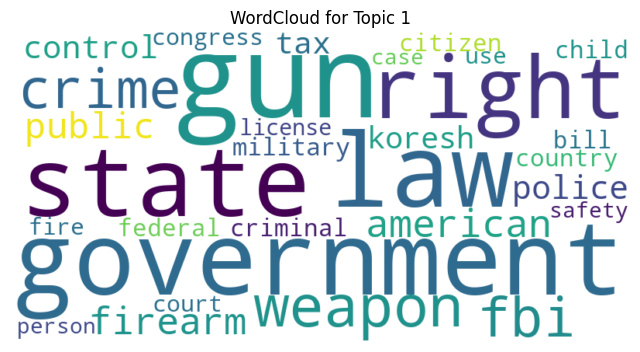

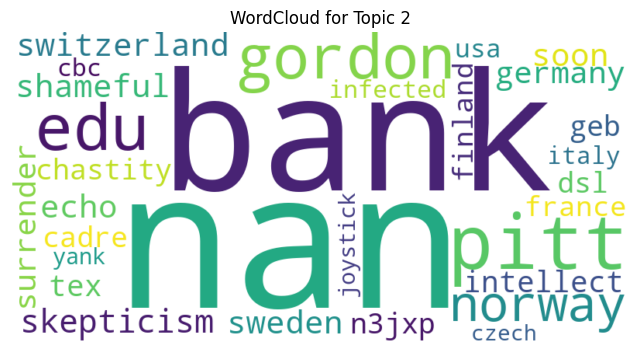

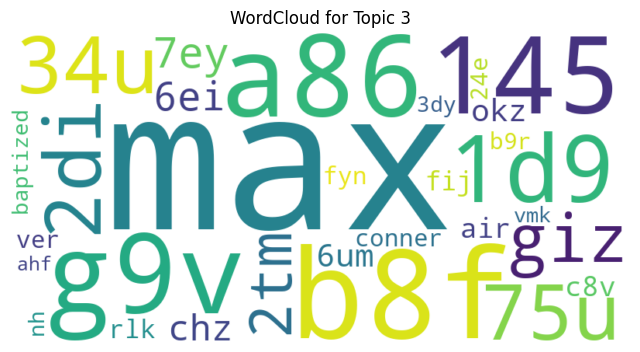

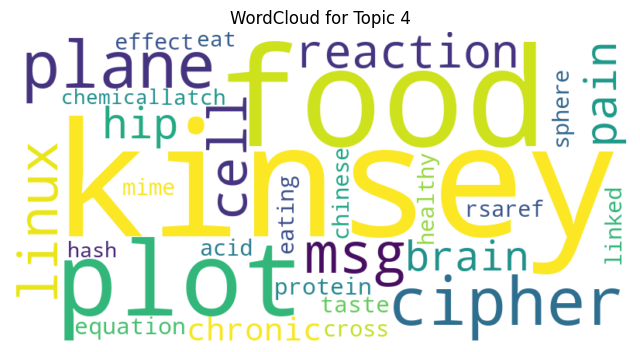

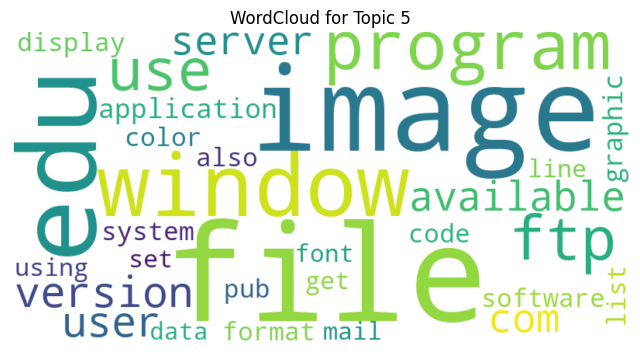

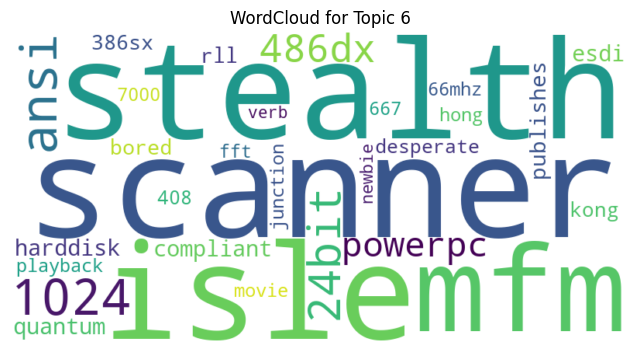

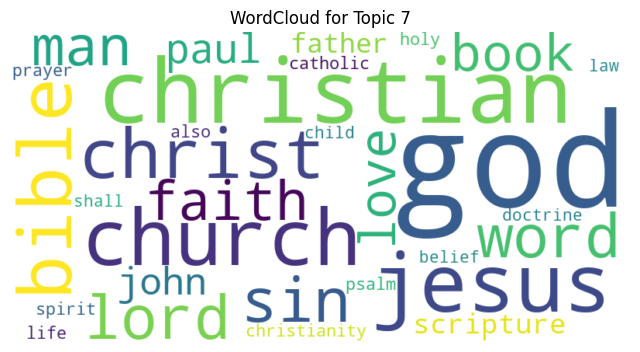

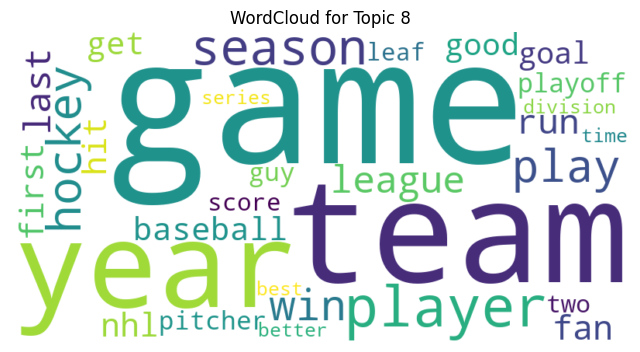

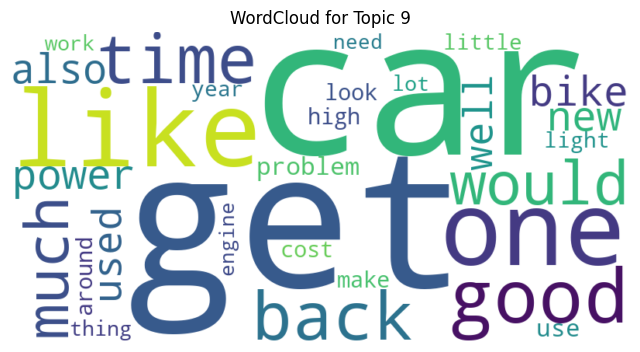

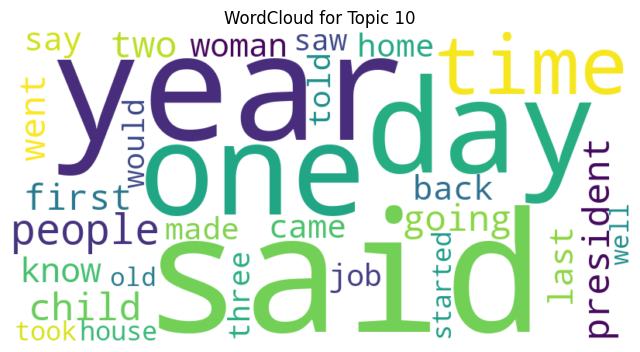

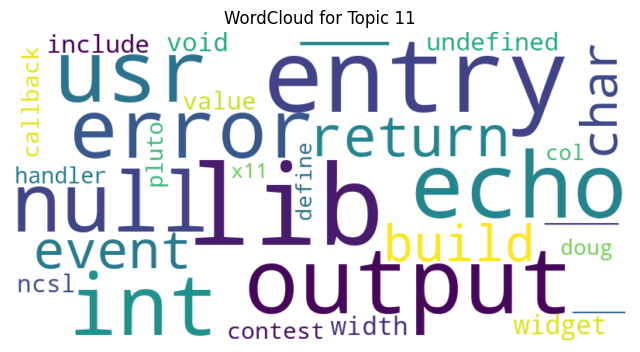

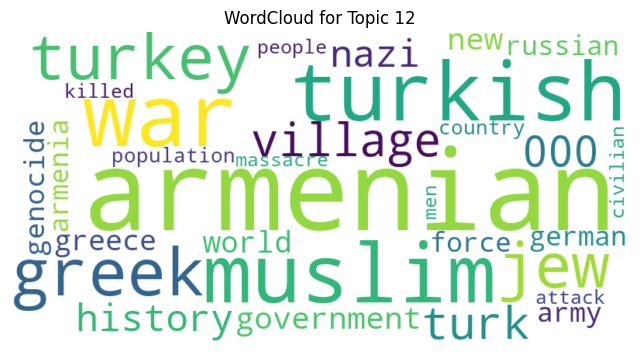

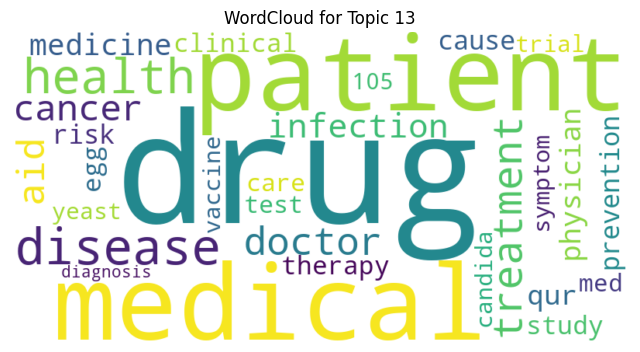

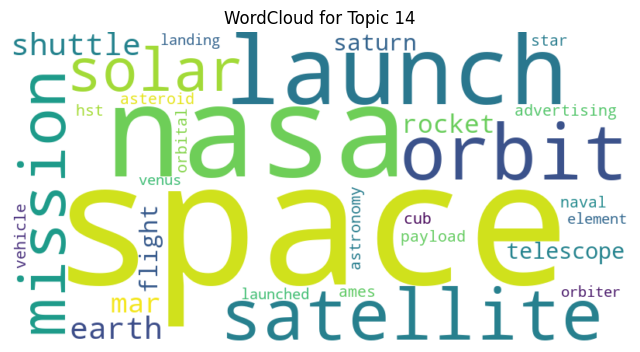

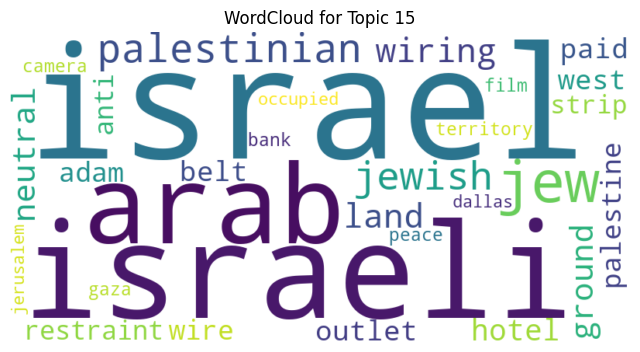

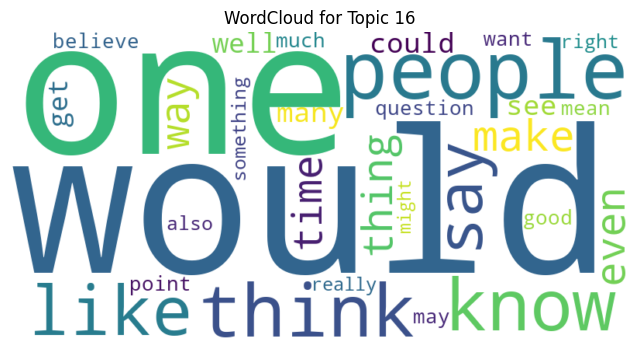

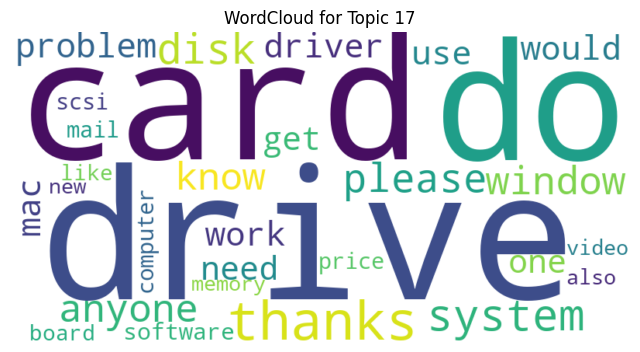

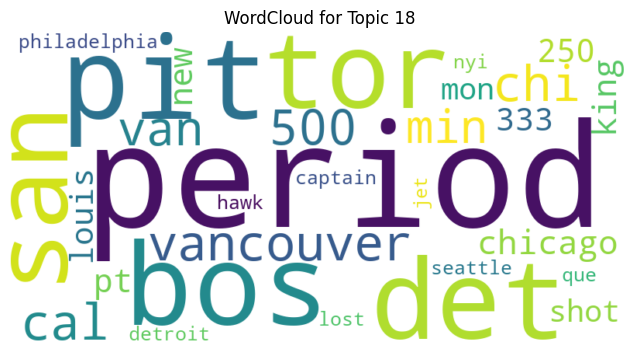

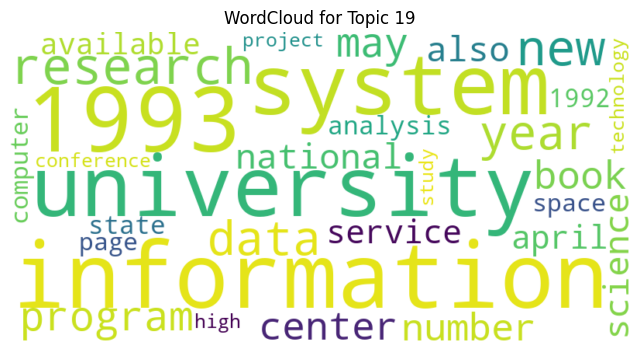

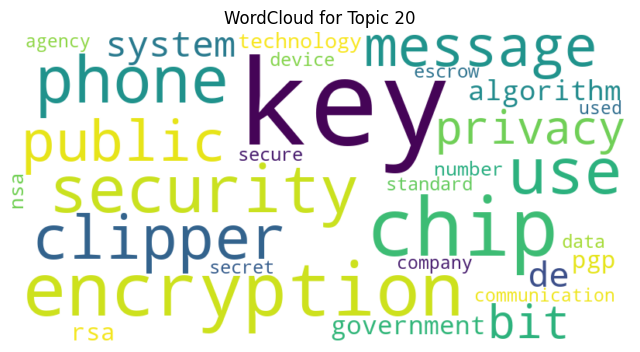

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create WordCloud for each topic
for t in range(lda_model.num_topics):
    plt.figure(figsize=(8,6))
    plt.title(f'WordCloud for Topic {t+1}')
    
    # Get topic words and their weights
    topic_words = dict(lda_model.show_topic(t, 30))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [7]:
import pyLDAvis
import pyLDAvis.gensim_models

# Prepare pyLDAvis visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.301231  0.030829       1        1  27.100766
4      0.206966 -0.212532       2        1   9.938950
8      0.250447 -0.034870       3        1   8.843640
16     0.236514 -0.200464       4        1   8.789641
18     0.180886 -0.037970       5        1   7.973763
9      0.201493  0.147897       6        1   7.748305
0      0.106241  0.141825       7        1   4.414603
6      0.055300  0.178038       8        1   4.314411
11     0.025612  0.203176       9        1   3.636289
7      0.087501  0.068296      10        1   3.162845
2     -0.221968 -0.036580      11        1   3.078579
19     0.087720 -0.124830      12        1   2.881172
17    -0.108984  0.061605      13        1   2.483229
14    -0.132723  0.034864      14        1   1.384774
3     -0.189362 -0.042986      15        1   1.110400
10    -0.191816 -0.065712      16        1   0.890662
12    -0.200911 -0.015886      17        1   0.828803
13    -0.208678 -0.027381      18        1   0.708925
1     -0.234508 -0.033577      19        1   0.458190
5     -0.250962 -0.033744      20        1   0.252053, topic_info=          Term         Freq        Total Category  logprob  loglift
310        max  9281.000000  9281.000000  Default  30.0000  30.0000
3306       god  4507.000000  4507.000000  Default  29.0000  29.0000
24141      b8f  2456.000000  2456.000000  Default  28.0000  28.0000
1590      file  4195.000000  4195.000000  Default  27.0000  27.0000
1719       key  2250.000000  2250.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
8163      esdi    22.211784    30.932055  Topic20  -5.3533   5.6521
8179   quantum    22.080626    74.050986  Topic20  -5.3592   4.7732
9180      verb    12.711374    18.732559  Topic20  -5.9114   5.5955
8945       408    16.510559   176.283574  Topic20  -5.6499   3.6152
1279     movie    15.200158   145.190070  Topic20  -5.7326   3.7265

[1219 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1156       3  0.206864      000
1156       4  0.016108      000
1156       5  0.209407      000
1156       6  0.044086      000
1156       7  0.077998      000
...      ...       ...      ...
18419     14  0.981443  zionism
4212       9  0.013596  zionist
4212      14  0.978947  zionist
6780       2  0.983577      zip
6780      10  0.013158      zip

[2979 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 5, 9, 17, 19, 10, 1, 7, 12, 8, 3, 20, 18, 15, 4, 11, 13, 14, 2, 6])

In [8]:
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(df['target'], df['kmeans_cluster'])
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")


Adjusted Rand Index (ARI): 0.0881


In [9]:
import pickle

# Save KMeans model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans_model, f)

# Save TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save LDA model (Gensim format)
lda_model.save('lda_model.gensim')


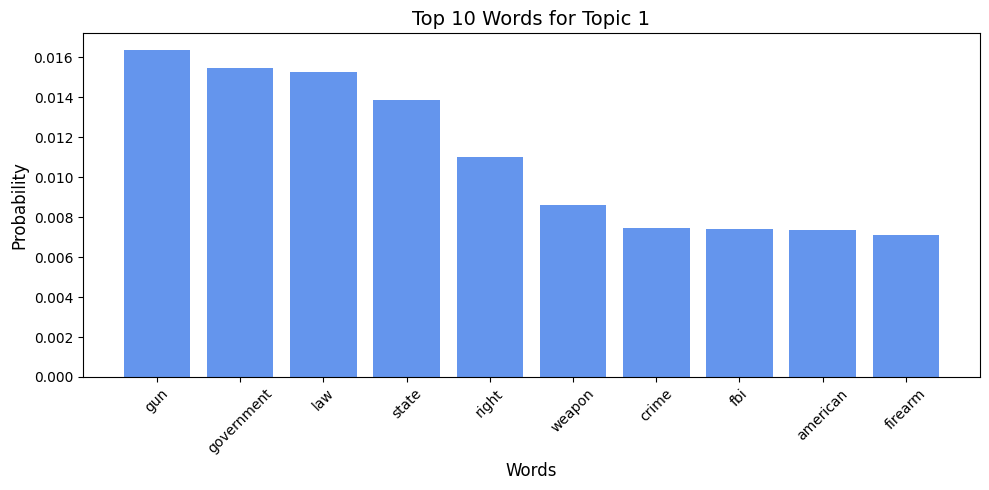

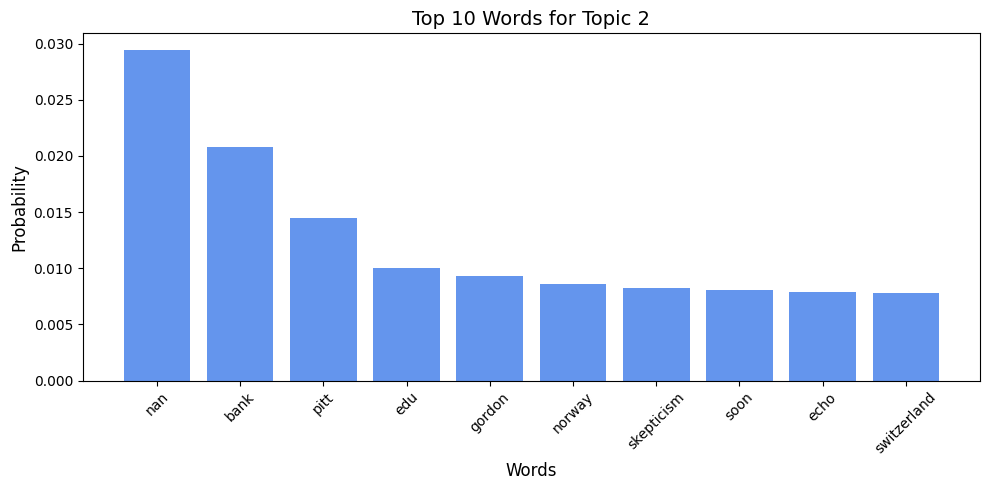

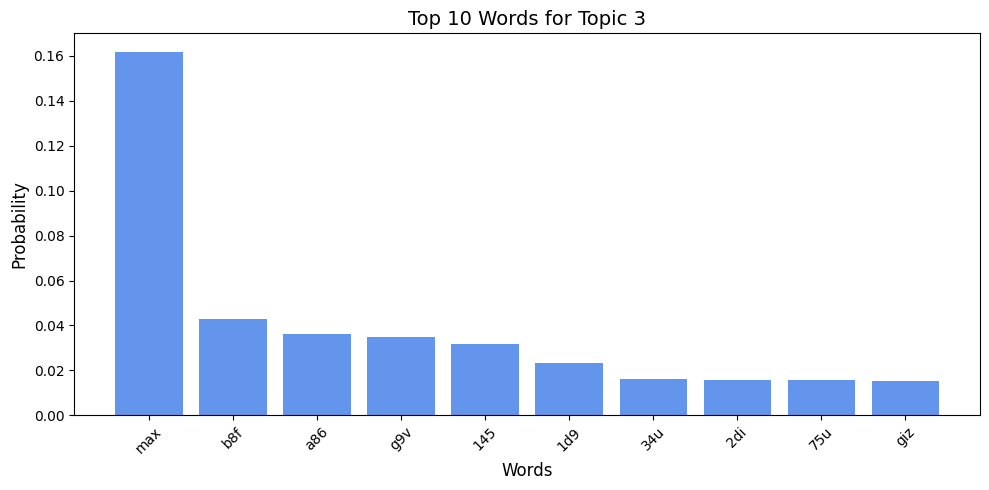

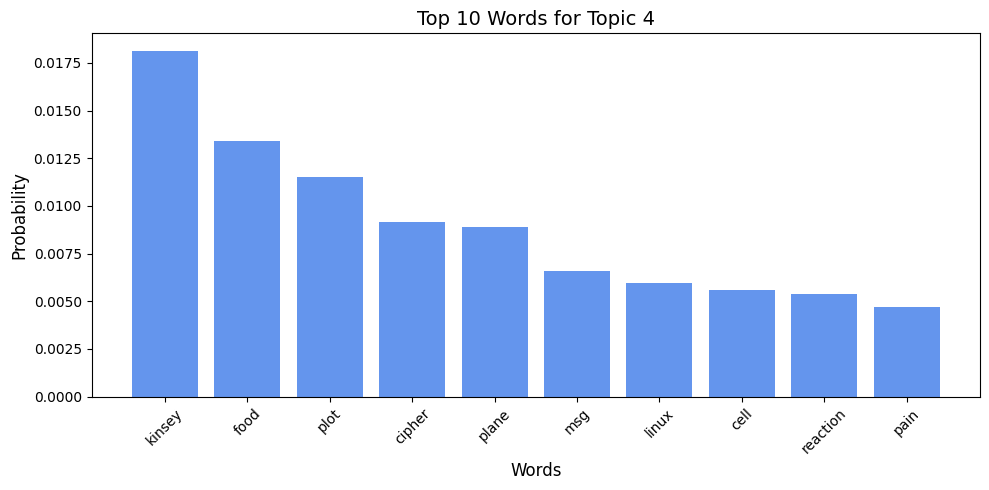

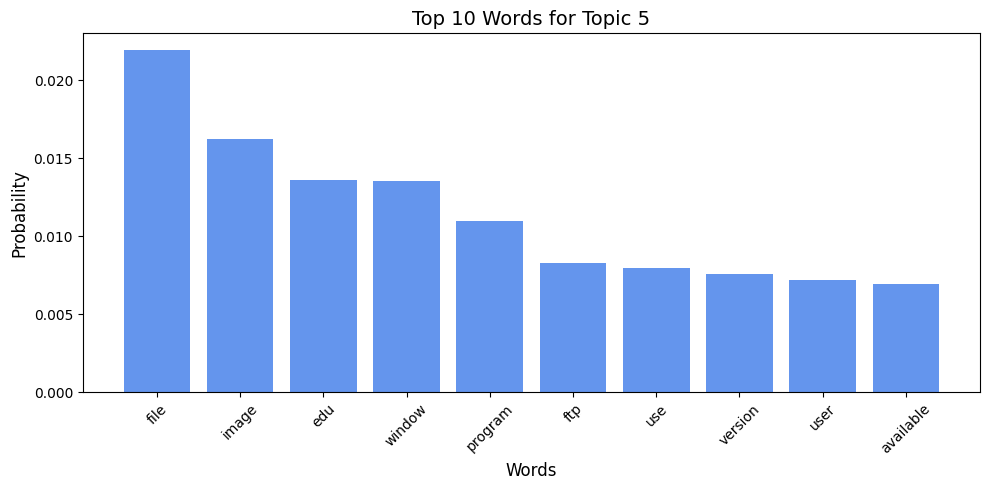

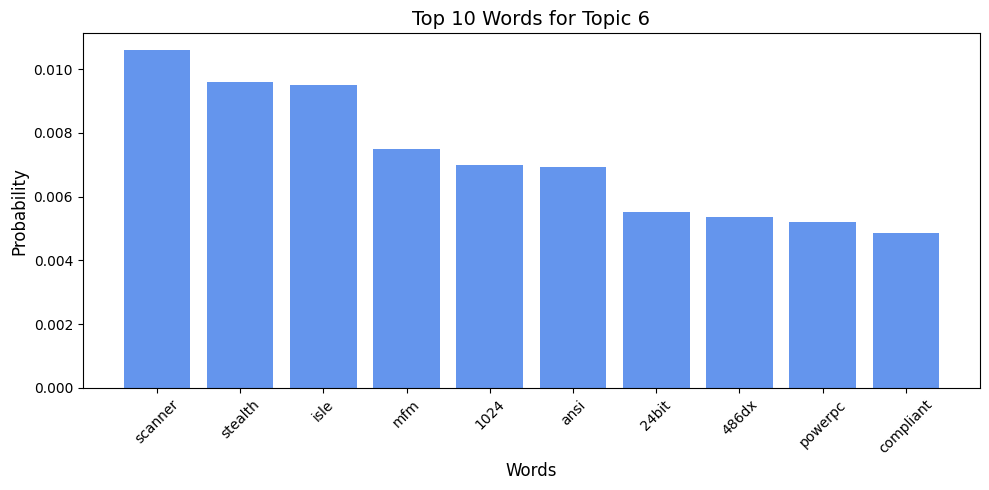

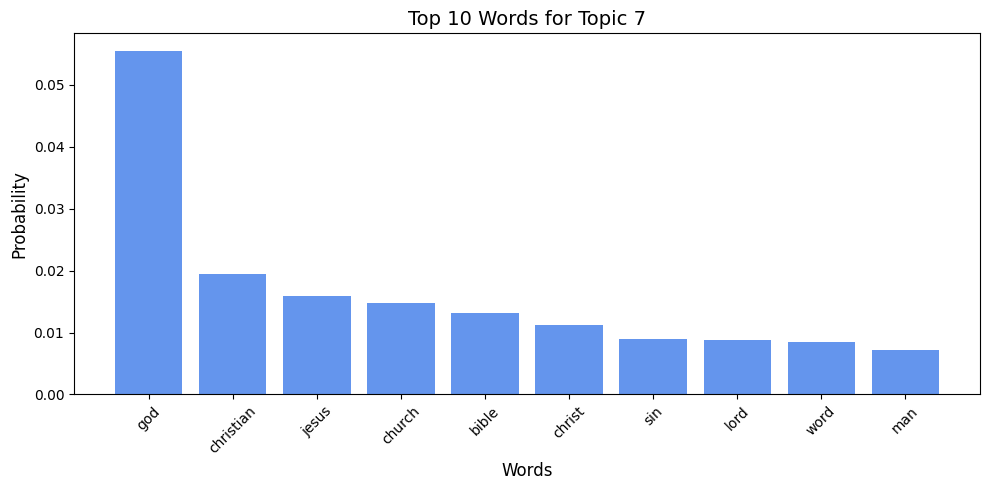

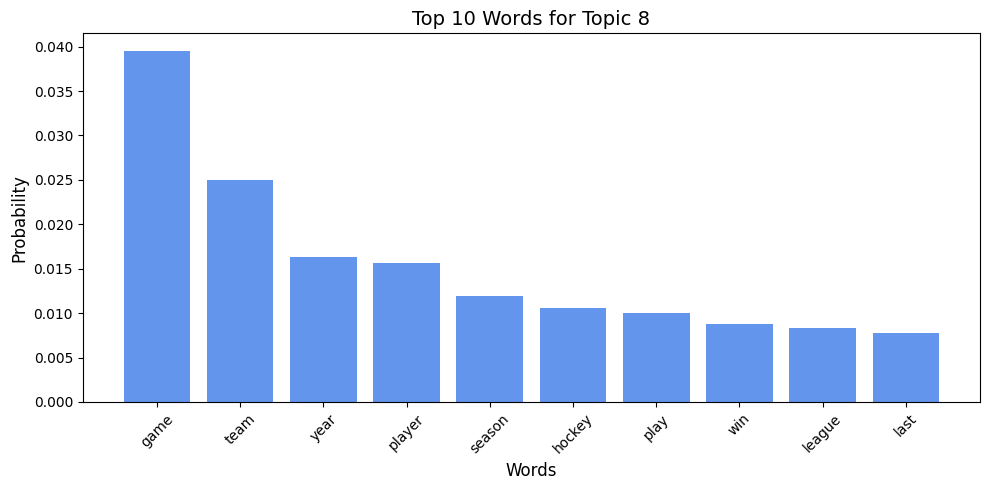

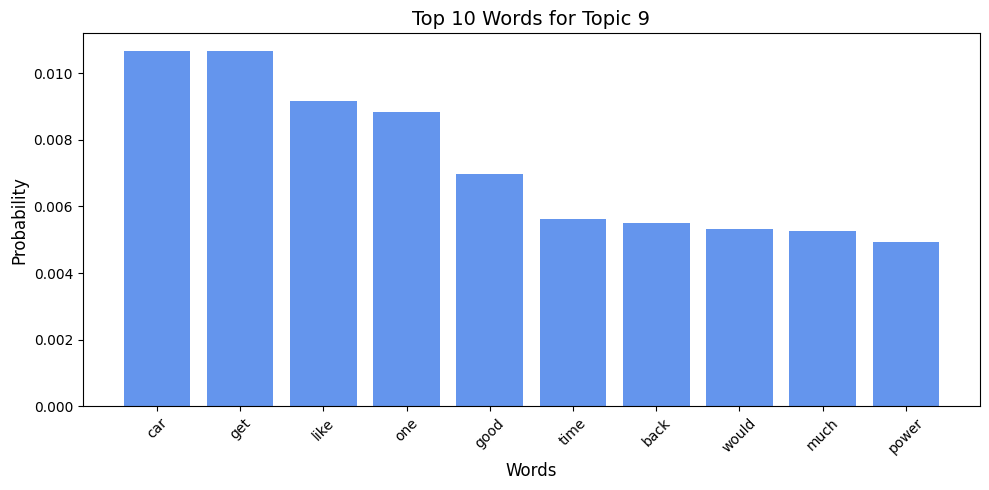

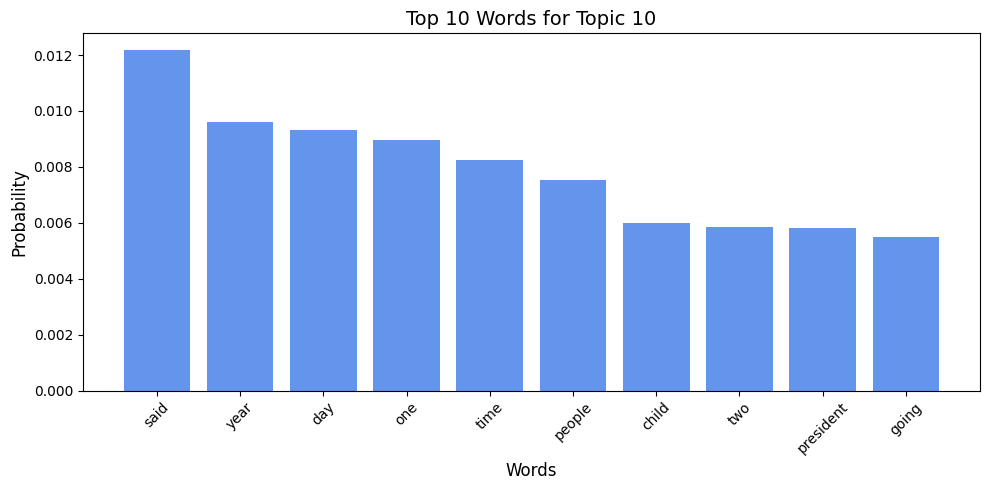

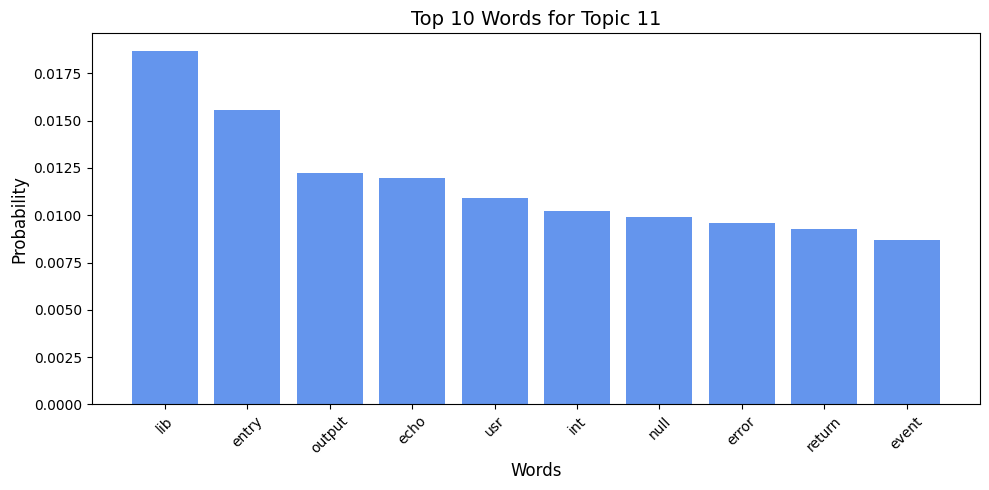

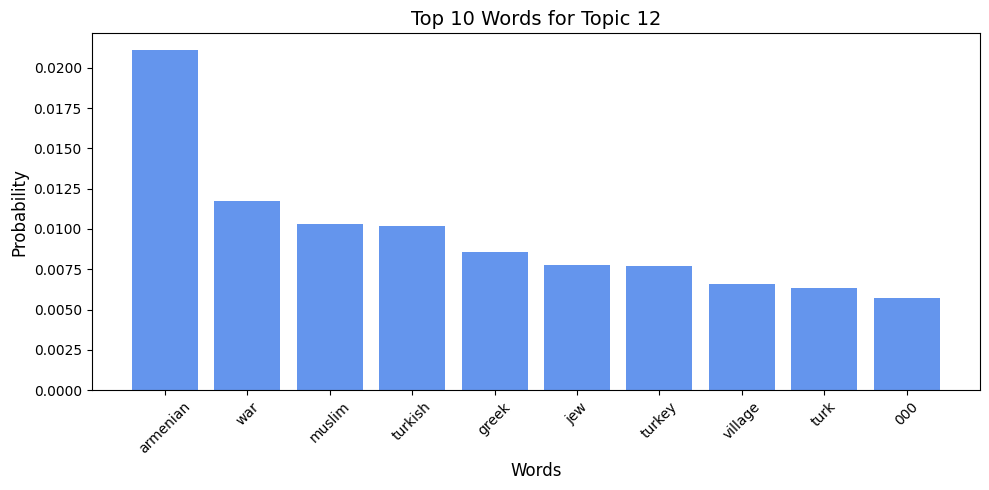

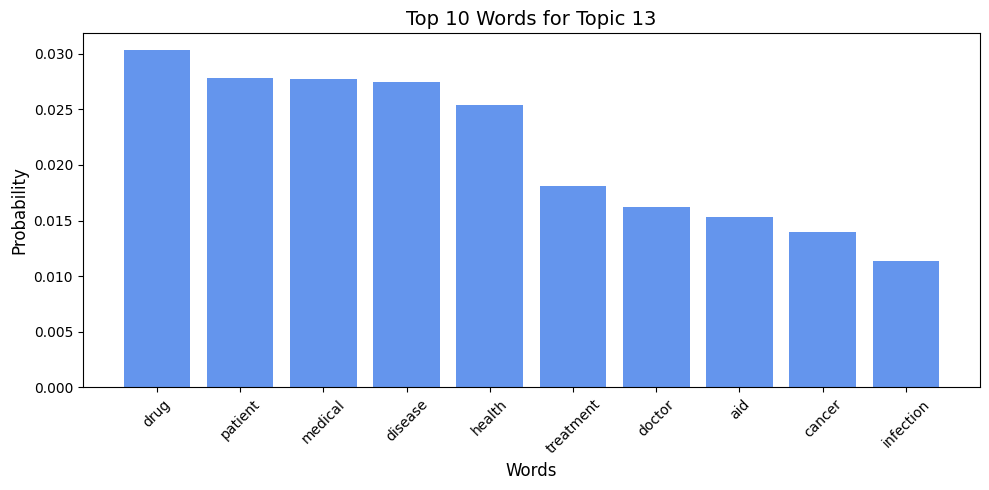

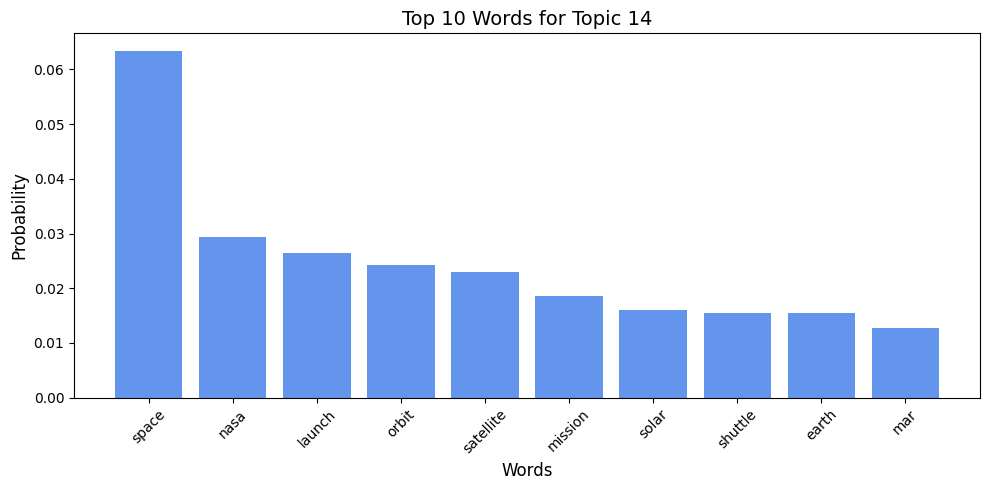

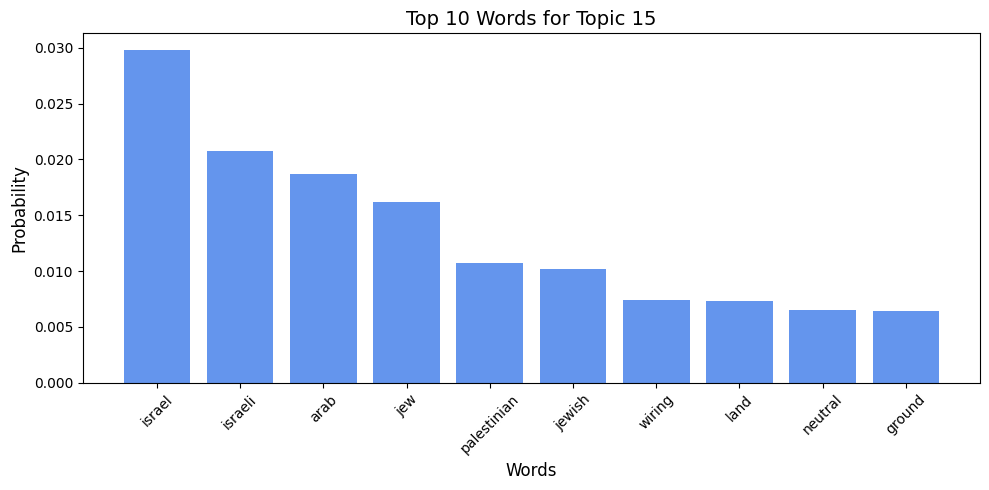

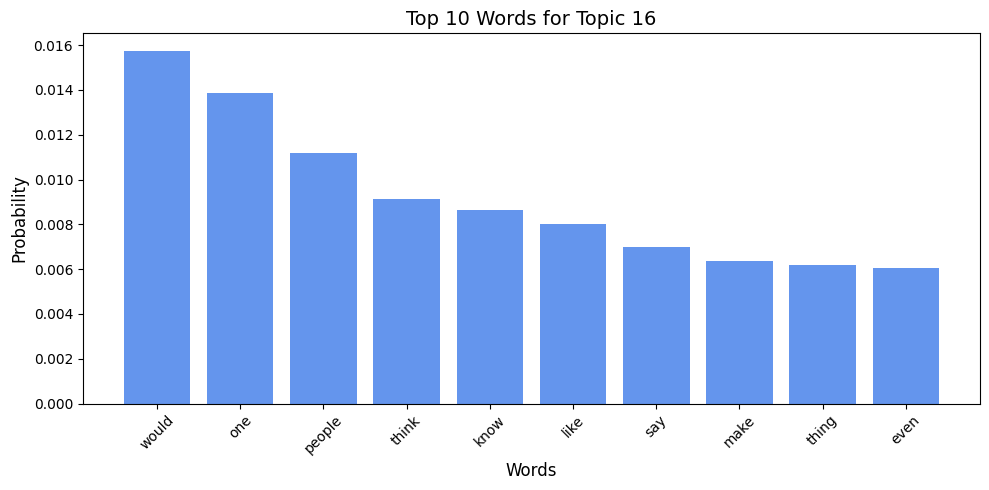

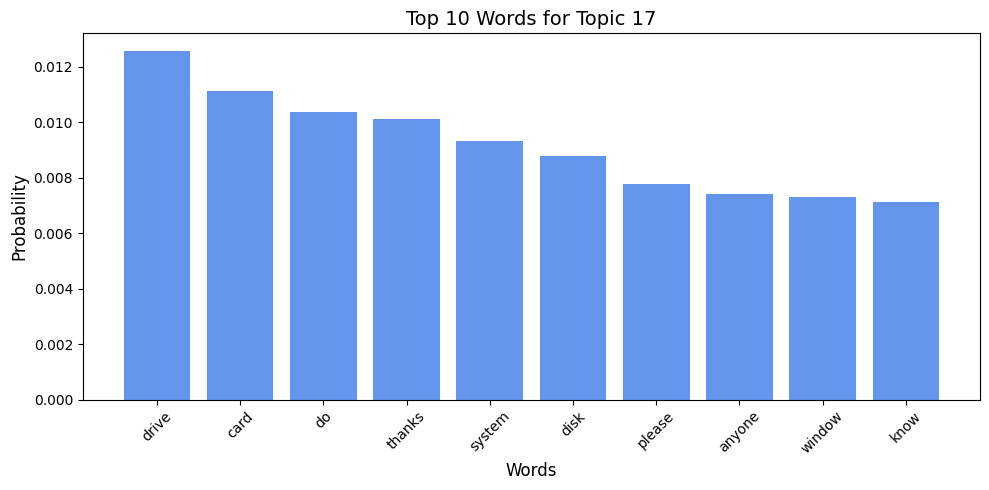

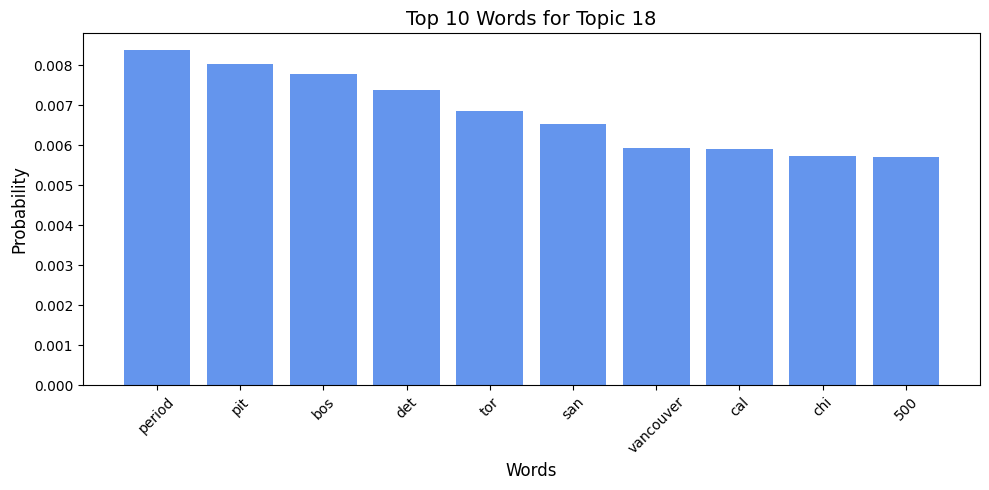

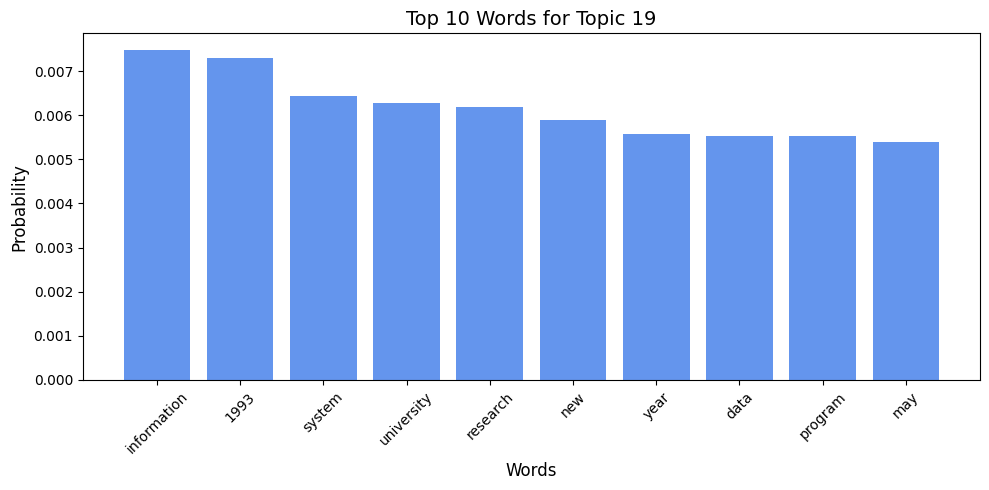

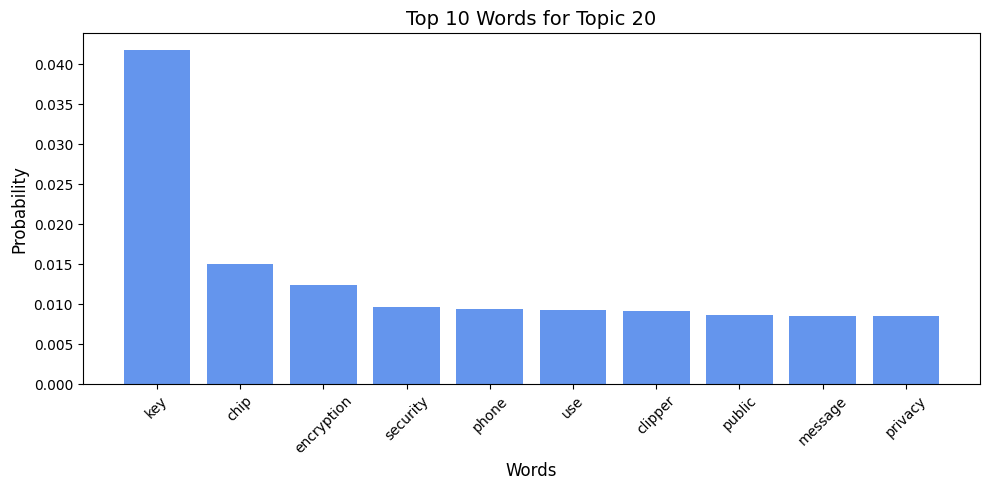

In [10]:
import matplotlib.pyplot as plt

# Bar chart of top 10 words per topic
for topic_id in range(lda_model.num_topics):
    plt.figure(figsize=(10, 5))
    plt.title(f"Top 10 Words for Topic {topic_id+1}", fontsize=14)
    
    # Extract top 10 words
    words_probs = lda_model.show_topic(topic_id, topn=10)
    words = [word for word, prob in words_probs]
    probs = [prob for word, prob in words_probs]

    # Plot bar chart
    plt.bar(words, probs, color='cornflowerblue')
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [11]:
# Function to extract dominant LDA topic
def get_dominant_topic(bow):
    topic_probs = lda_model.get_document_topics(bow)
    return max(topic_probs, key=lambda x: x[1])[0]

# Apply to all documents
df['lda_dominant_topic'] = [get_dominant_topic(bow) for bow in corpus]

# Final DataFrame for export
df_final = df[['cleaned_text', 'category', 'kmeans_cluster', 'lda_dominant_topic']]

# Save as CSV
df_final.to_csv('final_topic_modeling_output.csv', index=False)

# Preview
df_final.head()


,cleaned_text,category,kmeans_cluster,lda_dominant_topic
0,sure bashers pen fan pretty confused lack kind...,rec.sport.hockey,8,7
1,brother market high performance video card sup...,comp.sys.ibm.pc.hardware,1,16
2,finally said dream mediterranean new area grea...,talk.politics.mideast,7,9
3,think scsi card dma transfer disk scsi card dm...,comp.sys.ibm.pc.hardware,4,16
4,old jasmine drive cannot use new system unders...,comp.sys.mac.hardware,14,16


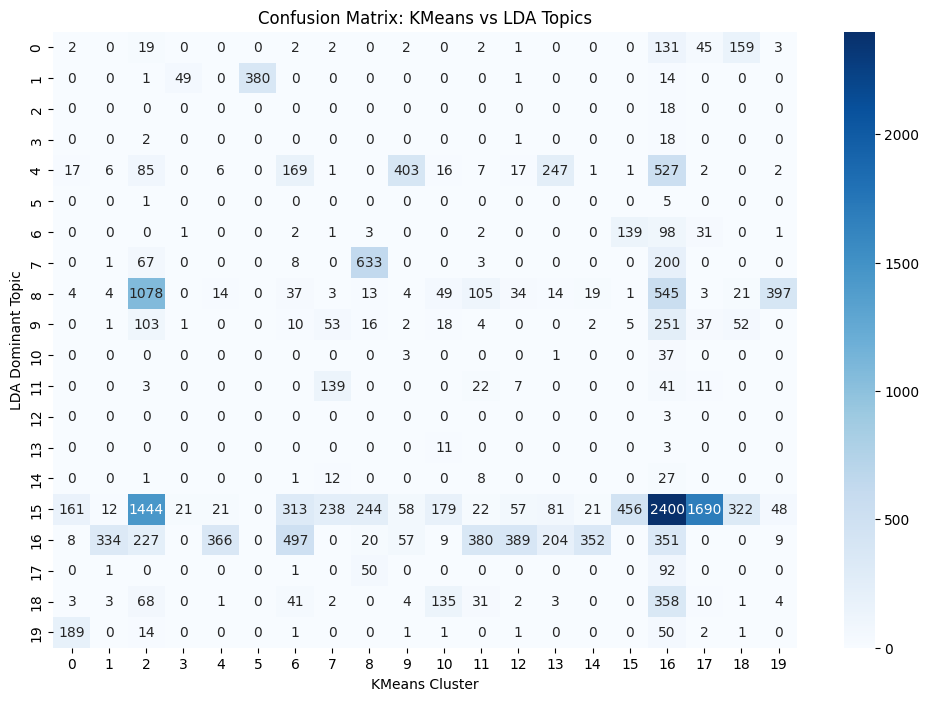

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(df['lda_dominant_topic'], df['kmeans_cluster'])

plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('KMeans Cluster')
plt.ylabel('LDA Dominant Topic')
plt.title('Confusion Matrix: KMeans vs LDA Topics')
plt.show()


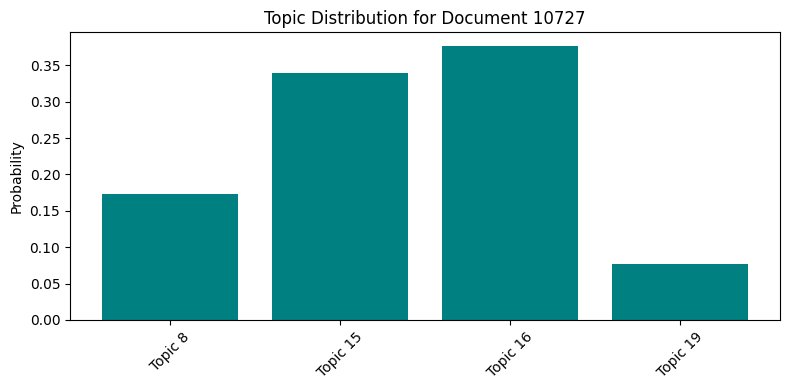

In [14]:
# Topic distribution of a random document
import random
doc_id = random.randint(0, len(corpus)-1)
topic_dist = lda_model.get_document_topics(corpus[doc_id])

# Plot
plt.figure(figsize=(8, 4))
plt.bar([f"Topic {i}" for i, _ in topic_dist], [prob for _, prob in topic_dist], color='teal')
plt.title(f"Topic Distribution for Document {doc_id}")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
sil_score = silhouette_score(tfidf_matrix, kmeans_model.labels_)
print(f"Silhouette Score for KMeans: {sil_score:.4f}")


Silhouette Score for KMeans: 0.0287


In [16]:
from gensim.models import CoherenceModel

# Calculate Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score for LDA Model: {coherence_lda:.4f}')


Coherence Score for LDA Model: 0.6501


In [17]:
from sklearn.decomposition import NMF

# Create NMF model with 20 topics
nmf_model = NMF(n_components=20, random_state=42)
nmf_W = nmf_model.fit_transform(tfidf_matrix)
nmf_H = nmf_model.components_

# Display top 10 words for each NMF topic
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\n📌 NMF Topics (Top 10 Words Each):")
for topic_idx, topic in enumerate(nmf_H):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx+1}: {' '.join(top_words)}")



📌 NMF Topics (Top 10 Words Each):
Topic 1: nan os2 edu comp com ibm bit mac programmer scsi
Topic 2: one think get thing time people like good say well
Topic 3: window do application program run manager font version running driver
Topic 4: game team player year hockey baseball season play win fan
Topic 5: drive scsi disk hard ide controller floppy meg do jumper
Topic 6: god jesus christian bible christ believe sin faith belief church
Topic 7: please thanks mail email address advance reply post send looking
Topic 8: key chip clipper encryption phone escrow bit algorithm system government
Topic 9: file format program image ftp gif directory graphic convert zip
Topic 10: armenian turkish muslim armenia genocide turkey turk russian azeri soviet
Topic 11: new sale offer price edu book space shipping condition com
Topic 12: card driver video bus graphic mode ati diamond isa vlb
Topic 13: edu geb dsl n3jxp cadre pitt chastity skepticism intellect shameful
Topic 14: car bike engine mile deale